In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


In [2]:
random_state = 100
scorer = make_scorer(f1_score)
#preprocess_params = {}

models = {'RandomForestClassifier': RandomForestClassifier(),
         'LogisticRegression': LogisticRegression(),
         #'SVC' : SVC()
         }

model_params = {'RandomForestClassifier':
              {'n_estimators':[10],
               'max_depth': [None, 15, 20, 25, 30],
              'min_samples_split' : [2, 3],
              'min_samples_leaf': [1, 3, 5, 7],
              'min_weight_fraction_leaf': [0],
              'max_features': ['auto'],
              'n_jobs': [-1],
              'random_state':[random_state],
              'class_weight':['balanced', None]
              },
            'LogisticRegression':{
                'penalty':['l1','l2'],
                'C':[1.e-1, 1, 1.e1]
            },
            'SVC':
              {'C':[1.e-05, 1.e-03, 1.e-01],
              'kernel':['rbf', 'linear'],
              'gamma' : ['auto', 1.e-01],
              'shrinking':[True, False],
              'class_weight':['balanced'],
              'random_state':[random_state]},
         }

In [3]:
#loading data
def load_train():
    DATA_FILE_TRAIN = '../../data/label_model_output/df_train_filtered.csv'
    df = pd.read_csv(DATA_FILE_TRAIN)
    comments = df.Cleaned_Text.values
    y = np.round(df.prob)
    
    return comments, y

def load_test():
    DATA_FILE_TEST = '../../data/label_model_output/df_test.csv'
    df = pd.read_csv(DATA_FILE_TEST)
    comments = df.Cleaned_Text.values
    y = df.human_label.values
    
    return comments, y

def base_model(X):
    '''Returns all 1s'''
    return np.ones(X.shape[0])

******************** RandomForestClassifier ********************
BEST ESTIMATOR
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=100, verbose=0,
                       warm_start=False)
BEST SCORE
0.85008150403646
BEST_PARAMS
{'class_weight': None, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 100}
Base f1 : 0.20209059233449478
Train f1 : 0.8962907827812927
Test f1 : 0.27411167512690354
******************** LogisticRegression **************

findfont: Font family ['RandomForestClassifier'] not found. Falling back to DejaVu Sans.


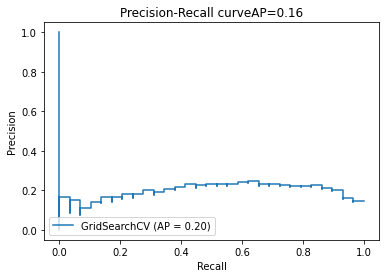

findfont: Font family ['LogisticRegression'] not found. Falling back to DejaVu Sans.


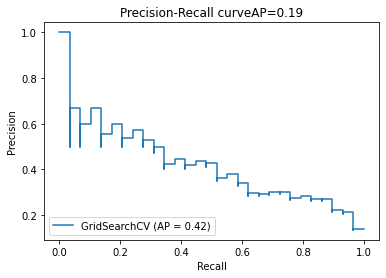

In [4]:
def main():
    comments_train, y_train = load_train()
    comments_test, y_test = load_test()
    
    tfidf = TfidfVectorizer(list(comments_train), strip_accents='unicode', decode_error= 'strict',
                        stop_words = 'english',
                       ngram_range=(1,1))

    X_train = tfidf.fit_transform(comments_train)
    X_test = tfidf.transform(comments_test)
    
    for model_name, model in models.items():
        print("**"*10, model_name, "**"*10)
        final_model = GridSearchCV(model, model_params[model_name],scoring= scorer, n_jobs= -1, cv = 5, verbose= 0)
        final_model.fit(X_train, y_train)

        pred_train = final_model.predict(X_train)
        pred_test = final_model.predict(X_test)
        pred_base = base_model(X_test)

        print('BEST ESTIMATOR')
        print(final_model.best_estimator_)
        print('BEST SCORE')
        print(final_model.best_score_)
        print('BEST_PARAMS')
        print(final_model.best_params_)

        print('Base f1 :', f1_score(y_test, pred_base))
        print('Train f1 :', f1_score(y_train, pred_train))
        print('Test f1 :', f1_score(y_test, pred_test))
        
        avg_precision_test = average_precision_score(y_test, pred_test)
        
        disp = plot_precision_recall_curve(final_model, X_test, y_test)
        disp.ax_.set_title('Precision-Recall curve'
                   'AP={0:0.2f}'.format(avg_precision_test), name = model_name)
        
        
if __name__ == "__main__":
    main()